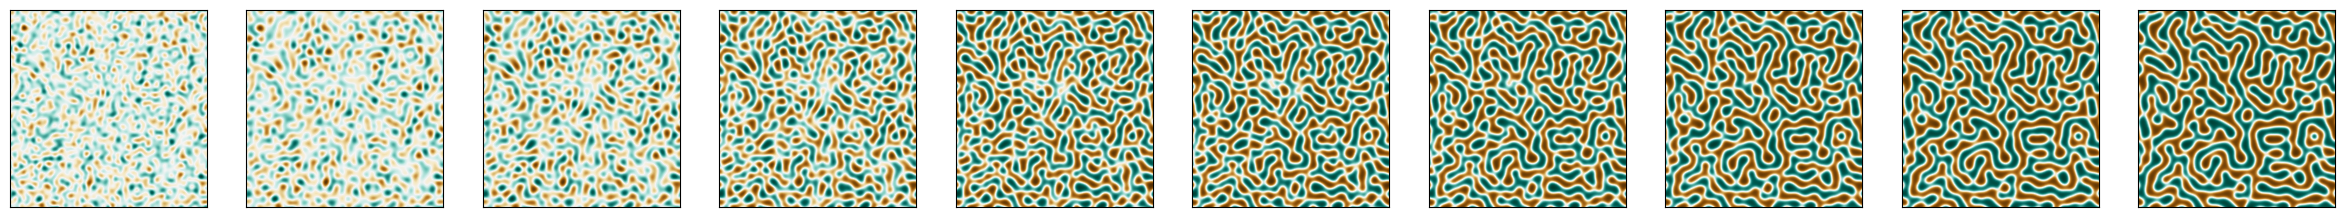

In [18]:
import torch 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sys; sys.path.append("..")

torch.set_grad_enabled(False)
torch.set_default_device("cuda")
torch.manual_seed(10)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
})

dt_long = 0.5
dt_short = 0.05

d = torch.tensor(np.load("ch2d_long.npy"))
n_plots = 10
fig, ax = plt.subplots(1, n_plots, figsize=(30, 4))
for k in range(n_plots):
    ax[k].imshow(d[k*d.shape[0]//n_plots,:,:].cpu().numpy(), cmap="BrBG")
    ax[k].set_xticks([])
    ax[k].set_yticks([])


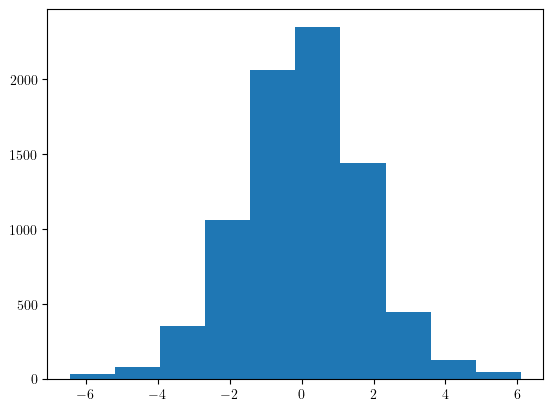

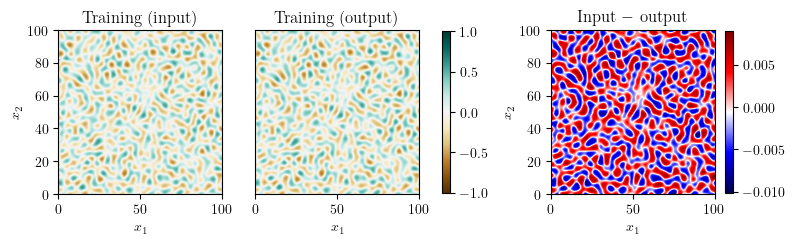

In [19]:
from model import ELM2D
from wrapper import CH2DModelWrapper

d = torch.tensor(np.load("ch2d_short.npy"))
i = 0
X, Y = d[i,None,:,:], d[i+1,None,:,:]

model = CH2DModelWrapper(ELM2D((4,4),(4,4),hidden=500))
model.train(X, Y, stopping_threshold=1e-5, noise=1e-3)
plt.hist(model.model.lout.weight.data.cpu().flatten())
plt.show()

# plots training data
fig, ax = plt.subplots(1, 3, figsize=(9,3))
im1 = ax[0].imshow(d[i,:,:].cpu(), vmin=-1, vmax=1, cmap="BrBG", extent=[0,100,0,100])
im2 = ax[1].imshow(d[i+1,:,:].cpu(), vmin=-1, vmax=1, cmap="BrBG", extent=[0,100,0,100])
im3 = ax[2].imshow((d[i,:,:]-d[i+1,:,:]).cpu(), cmap="seismic", extent=[0,100,0,100])

ax[0].set_xlabel("$x_1$")
ax[1].set_xlabel("$x_1$")
ax[2].set_xlabel("$x_1$")

ax[0].set_ylabel("$x_2$")
ax[1].set_yticks([])
ax[2].set_ylabel("$x_2$")
ax[0].set_title("Training (input)")
ax[1].set_title("Training (output)")
ax[2].set_title("Input $-$ output")

plt.colorbar(im1,ax=ax[:2], shrink=0.7, aspect=20, pad=0.05)
plt.colorbar(im3,ax=ax[2], shrink=0.7, aspect=20, pad=0.05)
plt.savefig("plots/ch2d_training.pdf", format="pdf", bbox_inches="tight")
plt.show()

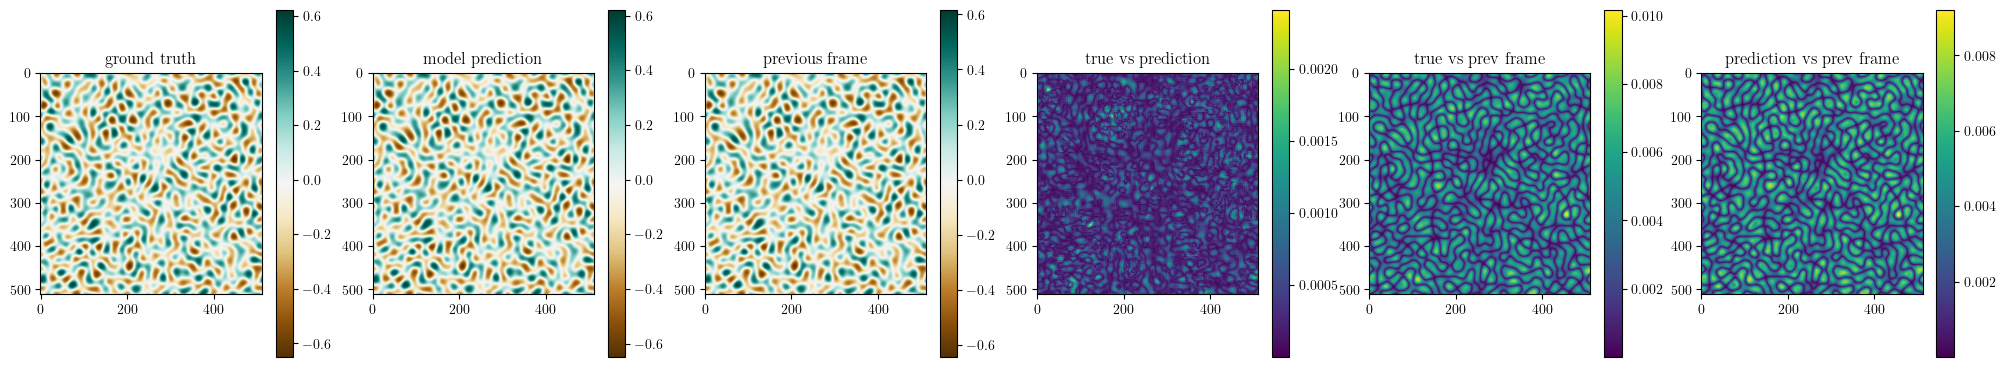

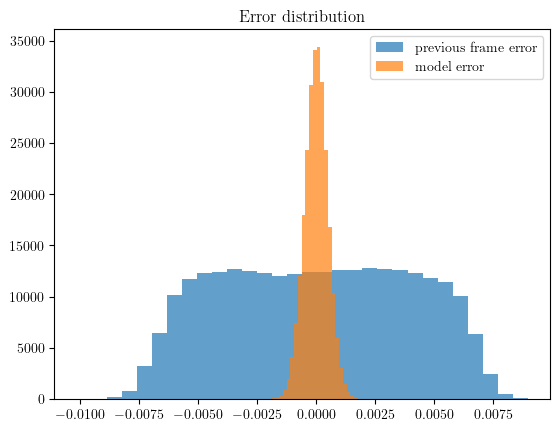

In [20]:
# i = torch.randint(high=d.shape[0]-1, size=(1,))[0]
X_test = d[i,...]
Y_test = d[i+1,...].cpu()
Y_pred = model(X_test).cpu()
X_test = X_test.cpu()

fig, ax = plt.subplots(1,6,figsize=(25,15))
plt.colorbar(ax[0].imshow(Y_test,cmap="BrBG"),shrink=0.3)
ax[0].set_title("ground truth")
plt.colorbar(ax[1].imshow(Y_pred,cmap="BrBG"),shrink=0.3)
ax[1].set_title("model prediction")
plt.colorbar(ax[2].imshow(X_test,cmap="BrBG"),shrink=0.3)
ax[2].set_title("previous frame")

model_error = Y_pred - Y_test
plt.colorbar(ax[3].imshow(model_error.abs()),shrink=0.3)
ax[3].set_title("true vs prediction")
prev_error = X_test - Y_test
plt.colorbar(ax[4].imshow(prev_error.abs()),shrink=0.3)
ax[4].set_title("true vs prev frame")

model_error_prev = Y_pred - X_test
plt.colorbar(ax[5].imshow(model_error_prev.abs()),shrink=0.3)
ax[5].set_title("prediction vs prev frame")
plt.show()

plt.hist(prev_error.flatten(), bins=30, label="previous frame error", alpha=0.7)
plt.hist(model_error.flatten(), bins=30, label="model error", alpha=0.7)
plt.title("Error distribution")
plt.legend()
plt.show()


In [21]:
from tqdm.notebook import tqdm

d = torch.tensor(np.load("ch2d_long.npy"))
# d = d[d.shape[0]//2:,:,:]

d_pred = torch.empty(*d.shape)
T = d[0,...].clone()
for j in tqdm(range(d.shape[0])):
    d_pred[j,...] = T
    for _ in range(round(dt_long / dt_short)):
        T = model(T)
    print(T.mean(), end="\r")
d_pred = d_pred.cpu()
d = d.cpu()

  0%|          | 0/40 [00:00<?, ?it/s]

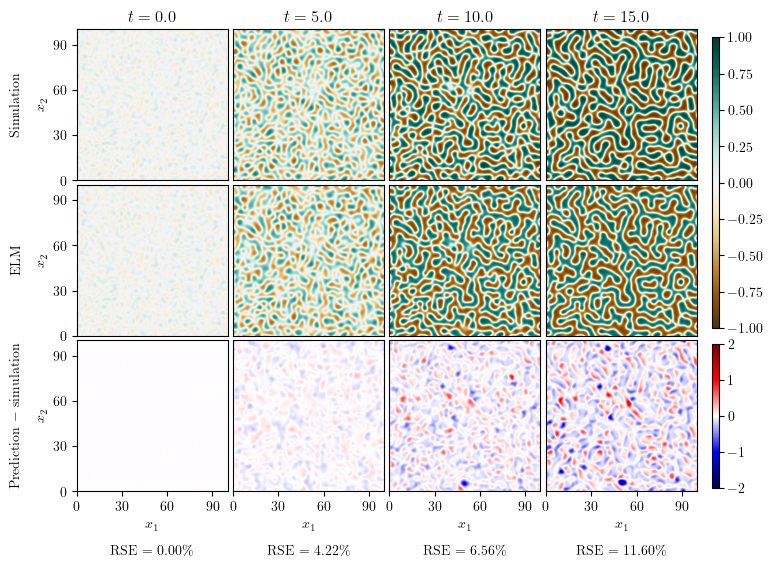

In [23]:
plt_step = 15

n_plots = 4
fig, ax = plt.subplots(3, n_plots, figsize=(10,6), gridspec_kw={"wspace":-.1,"hspace":.03})
L = 100
ext = [0,L,0,L]
for i in range(n_plots):
    k = i*d.shape[0]//n_plots

    im1 = ax[0][i].imshow( d[k,...].numpy(),      cmap="BrBG", vmax=1,vmin=-1,extent=ext)
    im2 = ax[1][i].imshow( d_pred[k,...].numpy(), cmap="BrBG", vmax=1,vmin=-1,extent=ext)
    if i > 0:
        ax[0][i].set_yticks([])
        ax[1][i].set_yticks([])
        ax[2][i].set_yticks([])
    ax[0][0].yaxis.set_major_locator(plt.MultipleLocator(30))
    ax[1][0].yaxis.set_major_locator(plt.MultipleLocator(30))
    ax[2][0].yaxis.set_major_locator(plt.MultipleLocator(30))
    ax[0][0].set_ylabel("$x_2$")
    ax[1][0].set_ylabel("$x_2$")
    ax[2][0].set_ylabel("$x_2$")
    ax[0][i].set_xticks([])
    ax[1][i].set_xticks([])
    ax[2][i].xaxis.set_major_locator(plt.MultipleLocator(30))
    ax[2][i].set_xlabel("$x_1$")

    t = dt_long * k
    residual = d_pred[k,...] - d[k,...]
    rse = 100 * residual.pow(2) / (d[k,...] - d[k,...].mean()).pow(2).mean()

    # im3 = ax[2][i].imshow(rse.numpy(),cmap="OrRd",extent=ext,norm=matplotlib.colors.LogNorm(vmin=0.1, vmax=10000))
    # im3 = ax[2][i].imshow(rse.numpy(),cmap="OrRd",extent=ext, vmin=0, vmax=100)
    im3 = ax[2][i].imshow(residual.numpy(),cmap="seismic",extent=ext, vmin=-2, vmax=2)

    ax[0][i].set_title(f"$t = {t:.1f}$")
    ax[2][i].text(L//2,-L//2.5,f"RSE = ${rse.mean():.2f}\%$",rotation="horizontal",horizontalalignment="center", verticalalignment="center")

ax[0][0].text(-L//2.5,L//2,"Simulation",rotation="vertical",horizontalalignment="center", verticalalignment="center")
ax[1][0].text(-L//2.5,L//2,"ELM",rotation="vertical",horizontalalignment="center", verticalalignment="center")
ax[2][0].text(-L//2.5,L//2,"Prediction $-$ simulation",rotation="vertical",horizontalalignment="center", verticalalignment="center")

plt.colorbar(im1, ax=[ax[i][j] for i in range(2) for j in range(n_plots)], shrink=0.95, pad=0.02, aspect=46)
plt.colorbar(im3, ax=[ax[2][j] for j in range(n_plots)], shrink=0.95, pad=0.02, aspect=23) # , format="{x:.2f}\%")

plt.savefig("plots/ch2d.pdf", format="pdf", bbox_inches="tight")
plt.show()
